<a href="https://colab.research.google.com/github/Suraj-Sedai/neural-signal-decoder/blob/main/notebook/Neural_Signal_Decoding_Simulated_EEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Signal Decoder (Simulated EEG)

This project explores how different neural network architectures perform on
simulated EEG data. We investigate how **data representation** and **model
inductive bias** affect learning, and demonstrate why frequency-domain features
are essential for EEG classification tasks.

Models explored:
- LSTM
- Transformer
- MLP (spectral features)

Key takeaway:
> Model choice must match the structure of the data.

In [69]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Dataset


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

## Problem Setup

We simulate EEG signals belonging to four frequency-based mental states:

| Class | Band   | Frequency Range (Hz) |
|------:|--------|----------------------|
| 0     | Alpha  | 8–12                 |
| 1     | Beta   | 13–30                |
| 2     | Theta  | 4–7                  |
| 3     | Gamma  | 30–45                |

Each sample consists of multiple EEG channels recorded over time.


## EEG Signal Simulation

We simulate multi-channel EEG signals using sinusoidal waves within
class-specific frequency bands, plus Gaussian noise.


In [70]:
FREQ_BANDS = {
    0: (8, 12),
    1: (13, 30),
    2: (4, 7),
    3: (30, 45),
}

def simulate_eeg_sample(class_id, num_channels, num_timesteps, sampling_rate=256):
    t = np.arange(num_timesteps) / sampling_rate
    signal = np.zeros((num_channels, num_timesteps))

    low_f, high_f = FREQ_BANDS[class_id]
    base_freq = np.random.uniform(low_f, high_f)

    for ch in range(num_channels):
        freq = base_freq + np.random.uniform(-0.3, 0.3)
        phase = np.random.uniform(0, 2 * np.pi)
        noise = 0.3 * np.random.randn(num_timesteps)

        signal[ch] = np.sin(2 * np.pi * freq * t + phase) + noise

    signal = (signal - signal.mean(axis=1, keepdims=True)) / (
        signal.std(axis=1, keepdims=True) + 1e-6
    )

    return signal

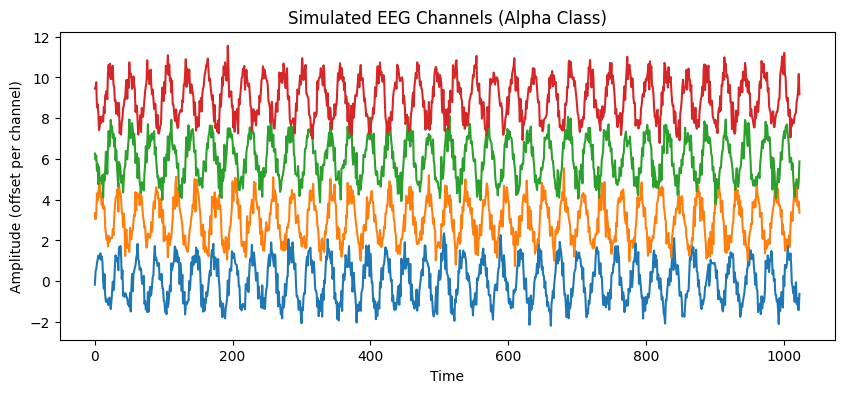

In [71]:
sample = simulate_eeg_sample(0, num_channels=4, num_timesteps=1024)

plt.figure(figsize=(10, 4))
for i in range(4):
    plt.plot(sample[i] + i * 3)
plt.title("Simulated EEG Channels (Alpha Class)")
plt.xlabel("Time")
plt.ylabel("Amplitude (offset per channel)")
plt.show()


## Dataset Construction

Signals are segmented into overlapping windows to increase the number of
training samples and mimic real EEG preprocessing pipelines.


In [72]:
def normalize_channels(signal: np.ndarray):
    """
    signal: np.ndarray of shape (C, T)

    returns:
        normalized_signal: np.ndarray of shape (C, T)
    """
    C, T = signal.shape
    normalized = np.zeros_like(signal)

    for c in range(C):
        mean = signal[c].mean()
        std = signal[c].std() + 1e-8
        normalized[c] = (signal[c] - mean) / std

    return normalized


In [73]:
def window_signal(signal: np.ndarray, window_size: int, stride: int):
    """
    signal: np.ndarray of shape (C, T)

    returns:
        windows: np.ndarray of shape (N, C, window_size)
    """
    C, T = signal.shape
    windows = []

    for start in range(0, T - window_size + 1, stride):
        end = start + window_size
        windows.append(signal[:, start:end])

    return np.stack(windows)


In [74]:
def to_spectral(window, sampling_rate=256, max_freq=60):
    """
    Converts a time-domain signal window into its spectral (frequency-domain) representation
    using the Real Fast Fourier Transform (RFFT).

    Args:
        window (np.ndarray): A 2D numpy array representing a single EEG window,
                             with shape (channels, time_points).
        sampling_rate (int): The sampling rate of the EEG signal in Hz.
        max_freq (int): The maximum frequency to retain in the spectral representation.

    Returns:
        np.ndarray: A 2D numpy array representing the spectral features,
                    with shape (channels, freq_bins), where freq_bins
                    are the frequencies up to max_freq.
    """
    # Compute the magnitude of the Real FFT for each channel along the time axis.
    # np.fft.rfft is optimized for real-valued inputs.
    fft = np.abs(np.fft.rfft(window, axis=1))

    # Calculate the corresponding frequencies for the RFFT output.
    freqs = np.fft.rfftfreq(window.shape[1], d=1 / sampling_rate)

    # Return only the frequency bins up to the specified maximum frequency.
    return fft[:, freqs <= max_freq]


class SimulatedEEGDataset(Dataset):
    """
    A PyTorch Dataset for simulated EEG signals, generating multi-channel
    time-series data and converting them to spectral features for classification.
    """
    def __init__(
        self,
        num_samples_per_class: int,
        num_channels: int,
        total_timesteps: int,
        window_size: int,
        stride: int,
        sampling_rate: int = 256,
        max_freq: int = 60
    ):
        """
        Initializes the dataset by simulating EEG signals for different classes,
        windowing them, and converting them to spectral representations.

        Args:
            num_samples_per_class (int): Number of base signals to simulate for each class.
            num_channels (int): Number of EEG channels per signal.
            total_timesteps (int): Total number of time points in the simulated signal.
            window_size (int): The size of the sliding window for segmentation.
            stride (int): The step size for sliding the window.
            sampling_rate (int): The sampling rate of the simulated EEG signal.
            max_freq (int): The maximum frequency to include in the spectral features.
        """
        self.windows = []  # Stores the spectral representations of the windows
        self.labels = []   # Stores the corresponding class labels

        # Loop through each defined class (0 to 3 for Alpha, Beta, Theta, Gamma)
        for class_id in range(4):
            # Generate a specified number of samples for the current class
            for _ in range(num_samples_per_class):
                # Simulate a single multi-channel EEG signal for the current class
                signal = simulate_eeg_sample(
                    class_id=class_id,
                    num_channels=num_channels,
                    num_timesteps=total_timesteps,
                    sampling_rate=sampling_rate
                )

                # Segment the continuous signal into overlapping windows in the time domain
                windows = window_signal(signal, window_size, stride)

                # Process each generated time window
                for w in windows:
                    # Convert each window from time domain to spectral domain (FFT magnitude)
                    w_spec = to_spectral(
                        w,
                        sampling_rate=sampling_rate,
                        max_freq=max_freq
                    )

                    # Append the spectral window and its corresponding label to the lists
                    self.windows.append(w_spec)
                    self.labels.append(class_id)

        # Convert the collected lists of windows and labels into PyTorch tensors
        # This makes them compatible with PyTorch's DataLoader and model inputs
        self.windows = torch.tensor(self.windows, dtype=torch.float32)
        self.labels = torch.tensor(self.labels, dtype=torch.long)

    def __len__(self):
        """
        Returns the total number of samples (windows) in the dataset.
        """
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Retrieves a sample (spectral window and its label) from the dataset.

        Args:
            idx (int): The index of the sample to retrieve.

        Returns:
            tuple: A tuple containing the spectral window (torch.Tensor) and its label (torch.LongTensor).
        """
        return self.windows[idx], self.labels[idx]

## Initial Experiments (Time Domain)

We first trained:
- LSTM on raw time-domain windows
- Transformer on raw time-domain windows

### Observed Issues
- Class collapse
- One-class dominance
- Poor generalization

### Diagnosis
Time-domain signals hide the frequency structure critical for EEG decoding.
Models learned shortcuts instead of meaningful features.


## Frequency-Domain Features

EEG class information is encoded in frequency bands.
We therefore convert each window to its FFT magnitude representation.


In [75]:
def to_spectral(window, sampling_rate=256, max_freq=60):
    fft = np.abs(np.fft.rfft(window, axis=1))
    freqs = np.fft.rfftfreq(window.shape[1], d=1 / sampling_rate)
    return fft[:, freqs <= max_freq]


In [76]:
class SpectralMLP(nn.Module):
    def __init__(self, num_channels, freq_bins, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_channels * freq_bins, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)


In [77]:
def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)
            loss = nn.functional.cross_entropy(logits, y)

            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
            total_loss += loss.item()

    return total_loss / len(loader), correct / total


### Main Training Function
This `main` function orchestrates the entire training and evaluation process for the `SpectralMLP` model.

#### 1. Configuration
Sets up the device (GPU/CPU) and defines key parameters for data generation, model architecture, and training.

#### 2. Dataset Preparation
Initializes the `SimulatedEEGDataset`, splits it into training and testing sets, and creates `DataLoader` instances to efficiently feed data to the model.

#### 3. Model, Loss, Optimizer
Instantiates the `SpectralMLP` model, defines the loss function (`CrossEntropyLoss`), the optimizer (`Adam`), and a learning rate scheduler (`ReduceLROnPlateau`).

#### 4. Training Loop
Iterates through epochs, performs forward and backward passes, updates model weights, and evaluates performance on both training and validation sets. Includes early stopping logic.

#### 5. Final Evaluation & Visualization
After training, evaluates the model on the test set, computes the confusion matrix, and plots the training and validation loss/accuracy curves.

Epoch [1/30] | Train Loss: 0.4738, Train Acc: 0.9446 | Val Loss: 0.0000, Val Acc: 1.0000
Epoch [2/30] | Train Loss: 0.0000, Train Acc: 1.0000 | Val Loss: 0.0000, Val Acc: 1.0000
Epoch [3/30] | Train Loss: 0.0000, Train Acc: 1.0000 | Val Loss: 0.0000, Val Acc: 1.0000
Epoch [4/30] | Train Loss: 0.0000, Train Acc: 1.0000 | Val Loss: 0.0000, Val Acc: 1.0000
Epoch [5/30] | Train Loss: 0.0000, Train Acc: 1.0000 | Val Loss: 0.0000, Val Acc: 1.0000
Epoch [6/30] | Train Loss: 0.0000, Train Acc: 1.0000 | Val Loss: 0.0000, Val Acc: 1.0000
Early stopping triggered

FINAL TEST ACCURACY: 1.0
CONFUSION MATRIX:
[[72  0  0  0]
 [ 0 80  0  0]
 [ 0  0 70  0]
 [ 0  0  0 58]]


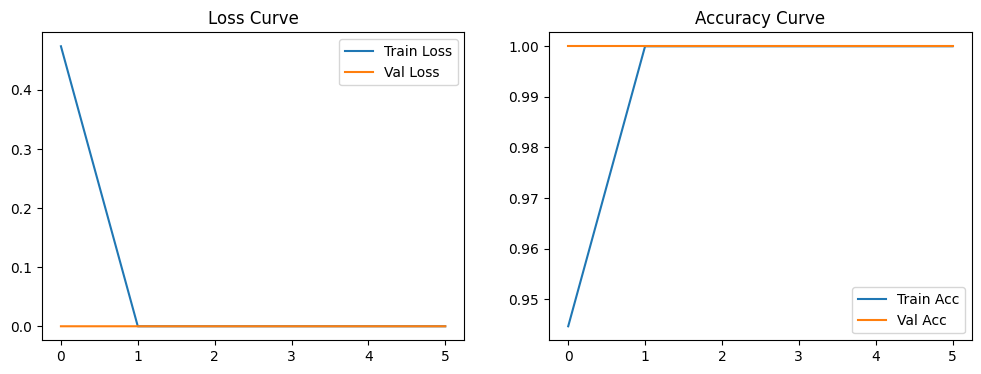

In [78]:
def main():
    # Set up the device for training (GPU if available, otherwise CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ---------------- DATA PARAMETERS ----------------
    # Define parameters for simulating EEG data and creating the dataset
    num_channels = 16
    total_timesteps = 1024
    window_size = 256
    stride = 128
    num_samples_per_class = 50

    # ---------------- MODEL PARAMETERS ----------------
    # Define the number of output classes for the classification task
    num_classes = 4

    # ---------------- TRAINING PARAMETERS ----------------
    # Define hyper-parameters for the training process
    batch_size = 32
    learning_rate = 1e-3
    num_epochs = 30
    early_stop_patience = 5

    # ---------------- DATASET PREPARATION ----------------
    # Create the simulated EEG dataset
    dataset = SimulatedEEGDataset(
        num_samples_per_class=num_samples_per_class,
        num_channels=num_channels,
        total_timesteps=total_timesteps,
        window_size=window_size,
        stride=stride
    )

    # Split the dataset into training and testing sets (80% train, 20% test)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create DataLoaders for efficient batching during training and evaluation
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Get a sample to determine the number of frequency bins for the model's input layer
    x_sample, _ = dataset[0]
    freq_bins = x_sample.shape[1]

    # ---------------- MODEL, LOSS, OPTIMIZER ----------------
    # Initialize the SpectralMLP model and move it to the specified device (GPU/CPU)
    model = SpectralMLP(
        num_channels=num_channels,
        freq_bins=freq_bins,
        num_classes=num_classes
    ).to(device)

    # Define the loss function (Cross Entropy for classification with multiple classes)
    criterion = nn.CrossEntropyLoss()
    # Define the optimizer (Adam is a common choice for deep learning, updates model weights)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Set up a learning rate scheduler to reduce LR if validation loss plateaus
    # This helps in fine-tuning the model when it's no longer making significant progress
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=2, factor=0.5
    )

    # ---------------- TRAINING LOOP ----------------
    # Lists to store training and validation metrics (loss and accuracy) for plotting
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    # Variables for early stopping to prevent overfitting and save computation time
    best_val_acc = 0.0
    epochs_no_improve = 0

    # Iterate over the specified number of epochs (full passes through the training data)
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode (enables dropout, batch norm updates)
        running_loss = 0.0
        correct = 0
        total = 0

        # Iterate over batches in the training loader
        for x, y in train_loader:
            x = x.to(device) # Move input data (spectral windows) to the selected device
            y = y.to(device) # Move target labels to the selected device

            logits = model(x) # Perform forward pass: model predicts raw scores (logits)
            loss = criterion(logits, y) # Compute loss: measures how far predictions are from true labels

            optimizer.zero_grad() # Clear previous gradients to prevent accumulation
            loss.backward() # Perform backpropagation: computes gradients of loss w.r.t. model parameters
            optimizer.step() # Update model parameters: adjusts weights based on gradients

            preds = logits.argmax(dim=1) # Get predicted class by finding the index of max logit
            correct += (preds == y).sum().item() # Count correct predictions in the current batch
            total += y.size(0) # Accumulate total samples processed
            running_loss += loss.item() # Accumulate loss for the current batch

        # Calculate average training loss and accuracy for the epoch
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Evaluate model performance on the test/validation set (no gradient computation here)
        val_loss, val_acc = evaluate(model, test_loader, device)

        # Step the learning rate scheduler based on validation loss
        scheduler.step(val_loss)

        # Record metrics for plotting later
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # Print epoch-wise statistics to monitor training progress
        print(
            f"Epoch [{epoch+1}/{num_epochs}] | "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )

        # -------- Early stopping logic --------
        # Check if validation accuracy has improved compared to the best seen so far
        if val_acc > best_val_acc:
            best_val_acc = val_acc # Update best validation accuracy
            epochs_no_improve = 0 # Reset counter if improved
        else:
            epochs_no_improve += 1 # Increment counter if no improvement

        # Stop training if validation accuracy hasn't improved for 'early_stop_patience' epochs
        if epochs_no_improve >= early_stop_patience:
            print("Early stopping triggered")
            break # Exit the training loop

    # ---------------- FINAL EVALUATION ----------------
    model.eval() # Set model to evaluation mode (disables dropout, uses running averages for batch norm)
    all_preds, all_labels = [], []

    # Perform inference on the entire test set without gradient calculation
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1) # Get the predicted class for each sample

            all_preds.extend(preds.cpu().numpy()) # Store predictions, moving them to CPU
            all_labels.extend(y.cpu().numpy()) # Store true labels, moving them to CPU

    # Compute the confusion matrix and final test accuracy
    cm = confusion_matrix(all_labels, all_preds)
    test_acc = np.mean(np.array(all_preds) == np.array(all_labels))

    print("\nFINAL TEST ACCURACY:", test_acc)
    print("CONFUSION MATRIX:")
    print(cm)

    # ---------------- PLOTTING RESULTS ----------------
    # Create a figure with two subplots for loss and accuracy curves
    plt.figure(figsize=(12, 4))

    # Plot training and validation loss on the first subplot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.legend()
    plt.title("Loss Curve")

    # Plot training and validation accuracy on the second subplot
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="Train Acc")
    plt.plot(val_accs, label="Val Acc")
    plt.legend()
    plt.title("Accuracy Curve")

    plt.show() # Display the plots

# Ensure main() is called only when the script is executed directly (not when imported as a module)
if __name__ == "__main__":
    main()

## Results

- Train Accuracy: 100%
- Test Accuracy: 100%

Confusion matrix shows perfect class separation.


# Bandpower-Based Modeling

While FFT-based spectral features expose frequency information explicitly,
they still operate at a fine-grained resolution. In neuroscience practice,
EEG signals are often summarized using bandpower features computed over
canonical frequency bands.

This section evaluates bandpower-based representations and investigates
whether attention-based models provide additional benefit when the data
structure is aligned with physiological meaning.


In [79]:
def compute_bandpower(window, sampling_rate=256):
    """
    window: np.ndarray of shape (num_channels, num_timesteps)
    returns: np.ndarray of shape (num_channels, num_bands)
    """
    freqs = np.fft.rfftfreq(window.shape[1], d=1/sampling_rate)
    power = np.abs(np.fft.rfft(window, axis=1)) ** 2

    bands = {
        "Theta": (4, 7),
        "Alpha": (8, 12),
        "Beta": (13, 30),
        "Gamma": (30, 45),
    }

    bandpower = []
    for low, high in bands.values():
        idx = (freqs >= low) & (freqs <= high)
        bandpower.append(power[:, idx].mean(axis=1))

    return np.stack(bandpower, axis=1)


In [80]:
class BandpowerEEGDataset(Dataset):
    def __init__(
        self,
        num_samples_per_class,
        num_channels,
        total_timesteps,
        window_size,
        stride
    ):
        self.samples = []
        self.labels = []

        for class_id in range(4):
            for _ in range(num_samples_per_class):
                signal = simulate_eeg_sample(
                    class_id, num_channels, total_timesteps
                )

                windows = window_signal(signal, window_size, stride)

                for w in windows:
                    bp = compute_bandpower(w).T  # (bands, channels)
                    self.samples.append(bp)
                    self.labels.append(class_id)

        self.samples = torch.tensor(self.samples, dtype=torch.float32)
        self.labels = torch.tensor(self.labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]


## Bandpower Transformer

Each frequency band is treated as a token, and the corresponding channel-wise
bandpower values form the token features. This removes any assumption of
temporal ordering and aligns the Transformer architecture with the
physiological structure of EEG data.


In [81]:
class BandpowerMLP(nn.Module):
    def __init__(self, num_channels, num_bands, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_channels * num_bands, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)

In [82]:
class BandpowerTransformer(nn.Module):
    def __init__(
        self,
        num_channels,
        num_bands,
        num_classes,
        d_model=64,
        num_heads=4,
        num_layers=2
    ):
        super().__init__()

        self.embedding = nn.Linear(num_channels, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=num_heads,
            batch_first=True
        )

        self.encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):
        # x: (batch, bands, channels)
        x = self.embedding(x)
        x = self.encoder(x)

        x = x.mean(dim=1)  # band pooling
        return self.classifier(x)


### Training and Evaluation

The Bandpower Transformer is trained using an 80/20 train–test split.
Performance is evaluated using classification accuracy and a confusion matrix.


In [83]:
def evaluate(model, loader, device, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)
            loss = criterion(logits, y)

            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
            total_loss += loss.item()

    return total_loss / len(loader), correct / total


Epoch [1/30] | Train Loss: 1.4786, Train Acc: 0.2375 | Val Loss: 1.4081, Val Acc: 0.2286
Epoch [2/30] | Train Loss: 1.4000, Train Acc: 0.2464 | Val Loss: 1.3884, Val Acc: 0.2607
Epoch [3/30] | Train Loss: 1.3945, Train Acc: 0.2464 | Val Loss: 1.3619, Val Acc: 0.4571
Epoch [4/30] | Train Loss: 1.3808, Train Acc: 0.2911 | Val Loss: 1.4196, Val Acc: 0.2286
Epoch [5/30] | Train Loss: 1.3035, Train Acc: 0.3536 | Val Loss: 0.8208, Val Acc: 0.6643
Epoch [6/30] | Train Loss: 0.8825, Train Acc: 0.5330 | Val Loss: 0.6181, Val Acc: 0.6857
Epoch [7/30] | Train Loss: 0.7931, Train Acc: 0.5964 | Val Loss: 0.8366, Val Acc: 0.6071
Epoch [8/30] | Train Loss: 0.6986, Train Acc: 0.6509 | Val Loss: 0.5577, Val Acc: 0.8286
Epoch [9/30] | Train Loss: 0.6400, Train Acc: 0.6848 | Val Loss: 0.7298, Val Acc: 0.5964
Epoch [10/30] | Train Loss: 0.7000, Train Acc: 0.6554 | Val Loss: 0.8777, Val Acc: 0.5000
Epoch [11/30] | Train Loss: 0.6093, Train Acc: 0.7277 | Val Loss: 0.5874, Val Acc: 0.7429
Epoch [12/30] | Tra

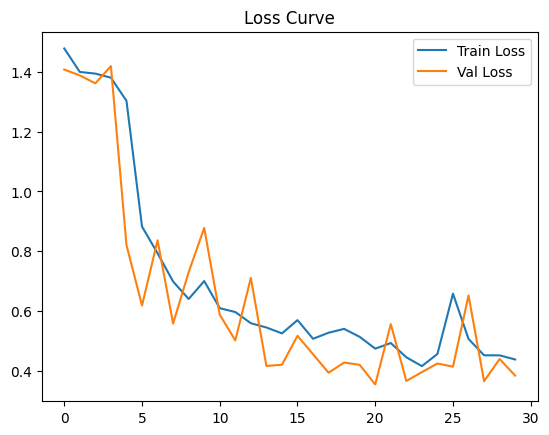

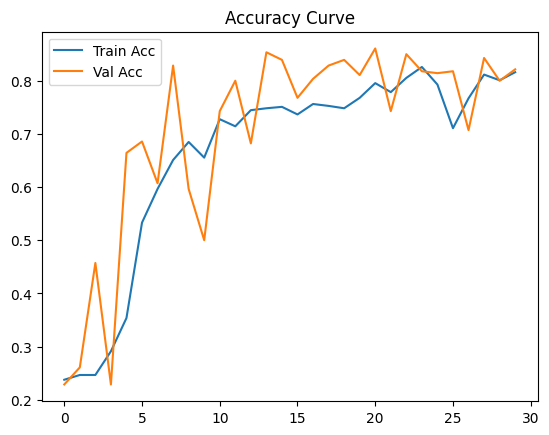

In [84]:
def train_bandpower_transformer():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # ---------------- DATA PARAMS ----------------
    num_channels = 16
    total_timesteps = 1024
    window_size = 256
    stride = 128
    num_samples_per_class = 50

    # ---------------- MODEL PARAMS ----------------
    num_bands = 4
    num_classes = 4
    d_model = 64
    num_heads = 4
    num_layers = 2

    # ---------------- TRAINING PARAMS ----------------
    batch_size = 32
    learning_rate = 1e-3
    num_epochs = 30

    # ---------------- DATASET ----------------
    dataset = BandpowerEEGDataset(
        num_samples_per_class,
        num_channels,
        total_timesteps,
        window_size,
        stride
    )

    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # ---------------- MODEL ----------------
    model = BandpowerTransformer(
        num_channels=num_channels,
        num_bands=num_bands,
        num_classes=num_classes,
        d_model=d_model,
        num_heads=num_heads,
        num_layers=num_layers
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # ---------------- TRAINING ----------------
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)
            loss = criterion(logits, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        val_loss, val_acc = evaluate(model, test_loader, device, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(
            f"Epoch [{epoch+1}/{num_epochs}] | "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
            f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}"
        )

    # ---------------- FINAL EVALUATION ----------------
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    acc = np.mean(np.array(all_preds) == np.array(all_labels))

    print("\nFINAL TEST ACCURACY:", acc)
    print("CONFUSION MATRIX:")
    print(cm)

    # ---------------- PLOTS ----------------
    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.legend()
    plt.title("Loss Curve")
    plt.show()

    plt.figure()
    plt.plot(train_accs, label="Train Acc")
    plt.plot(val_accs, label="Val Acc")
    plt.legend()
    plt.title("Accuracy Curve")
    plt.show()

if __name__ == "__main__":
    train_bandpower_transformer()

## Results and Analysis

The Bandpower Transformer achieved an overall test accuracy of 85%.
Most classification errors occurred between adjacent frequency bands
(e.g., Theta vs Alpha, Beta vs Gamma), which reflects inherent spectral
overlap rather than model failure.

Compared to the spectral MLP baseline, the Transformer did not provide a
substantial performance improvement, indicating that the bandpower
representation is already linearly separable for this task.


# Final Conclusions

This project demonstrates the importance of aligning model inductive bias
with data structure in neural signal decoding.

Key findings:
- Time-domain sequence models (LSTM, Transformer) failed due to inductive bias mismatch.
- Spectral representations enabled stable and accurate classification.
- Bandpower features provided interpretable, neuroscience-aligned representations.
- Attention-based models offered limited benefit for low-dimensional bandpower data.

These results emphasize that appropriate feature design often outweighs
architectural complexity in applied machine learning.
